In [1]:
import numpy as np
import pickle as pk
import os
# import libraries
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import array
from numpy import vstack

from pandas import read_csv
from pandas import DataFrame

import matplotlib.pyplot as plt

# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, sep=r'\s+')
	return dataframe.values

# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/InertialSignals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'dataset/')
	testX, testy = load_dataset_group('test', prefix + 'dataset/')
	trainy = trainy - 1
	testy = testy - 1
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

In [2]:
trainX, trainy, testX, testy = load_dataset() # prints out the shape of trainX, trainy, testX, testy

(7352, 128, 9) (7352, 1) (2947, 128, 9) (2947, 1)


In [3]:
from sklearn.model_selection import train_test_split
trainX, validX, trainy, validy = train_test_split(trainX, trainy, test_size=0.2, random_state=5483)

In [4]:
# summarize the balance of classes in an output variable column
def class_breakdown(data):
 # convert the numpy array into a dataframe
 df = DataFrame(data)
 # group data by the class value and calculate the number of rows
 counts = df.groupby(0).size()
 # retrieve raw rows
 counts = counts.values
 # summarize
 for i in range(len(counts)):
  percent = counts[i] / len(df) * 100
  print('Class=%d, total=%d, percentage=%.3f' % (i, counts[i], percent))

In [5]:
# summarize class breakdown
print('Train Dataset')
class_breakdown(trainy)

Train Dataset
Class=0, total=987, percentage=16.783
Class=1, total=855, percentage=14.538
Class=2, total=805, percentage=13.688
Class=3, total=1027, percentage=17.463
Class=4, total=1084, percentage=18.432
Class=5, total=1123, percentage=19.095


In [6]:
# plot a histogram of each variable in the dataset
def plot_variable_distributions(trainX):
  # remove overlap
  cut = int(trainX.shape[1] / 2)
  longX = trainX[:, -cut:, :]
  # flatten windows
  longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
  print(longX.shape)
  plt.figure()
  xaxis = None
  for i in range(longX.shape[1]):
    ax = plt.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
    ax.set_xlim(-1, 1)
    if i == 0:
      xaxis = ax
    plt.hist(longX[:, i], bins=100)
    plt.show()

(376384, 9)


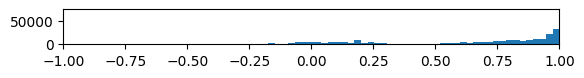

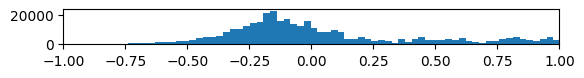

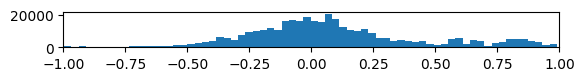

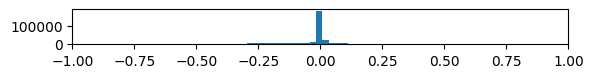

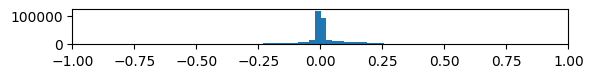

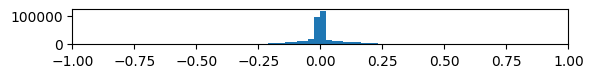

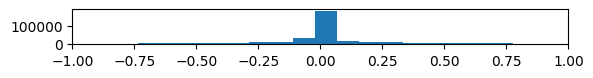

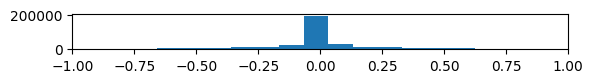

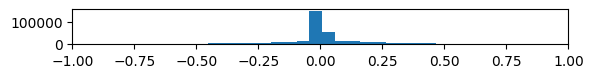

In [7]:
plot_variable_distributions(trainX)

In [8]:
# reshape the data to be used for scaler input

trainX = trainX.reshape((-1,128*9))
validX = validX.reshape((-1,128*9))
testX = testX.reshape((-1,128*9))

In [9]:
# standardize the dataset

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

motion_training_scaler = scaler.fit(trainX)
trainX = motion_training_scaler.transform(trainX)
validX = motion_training_scaler.transform(validX)
testX = motion_training_scaler.transform(testX)

In [10]:
# size has to be defined as (batch, n_timesteps, n_features) to be used for the input for neural network
trainX = trainX.reshape((-1,128,9))
validX = validX.reshape((-1,128,9))  
testX = testX.reshape((-1,128,9))

In [11]:
trainX.shape

(5881, 128, 9)

In [12]:
trainy.shape

(5881, 1)

In [13]:
testX.shape

(2947, 128, 9)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Create classifier
classifier = RandomForestClassifier(n_estimators=100,min_samples_split=5,min_samples_leaf=5)

In [15]:
# Convert to a one-dimensional array
trainy = trainy.ravel()
testy = testy.ravel()
trainX = trainX.reshape(trainX.shape[0], -1)
testX = testX.reshape(testX.shape[0], -1)

In [16]:
# train model
classifier.fit(trainX, trainy)

RandomForestClassifier(min_samples_leaf=5, min_samples_split=5)

In [17]:
# predict
predictions = classifier.predict(testX)

In [18]:
# compute accuracy, recall, precision 
accuracy = accuracy_score(testy, predictions)
print("Accuracy:", accuracy)

recall = recall_score(testy, predictions, average='macro')
print("Recall:", recall)

precision = precision_score(testy, predictions, average='macro')
print("Precision:", precision)

Accuracy: 0.837801153715643
Recall: 0.8356600695445144
Precision: 0.8350276286839726


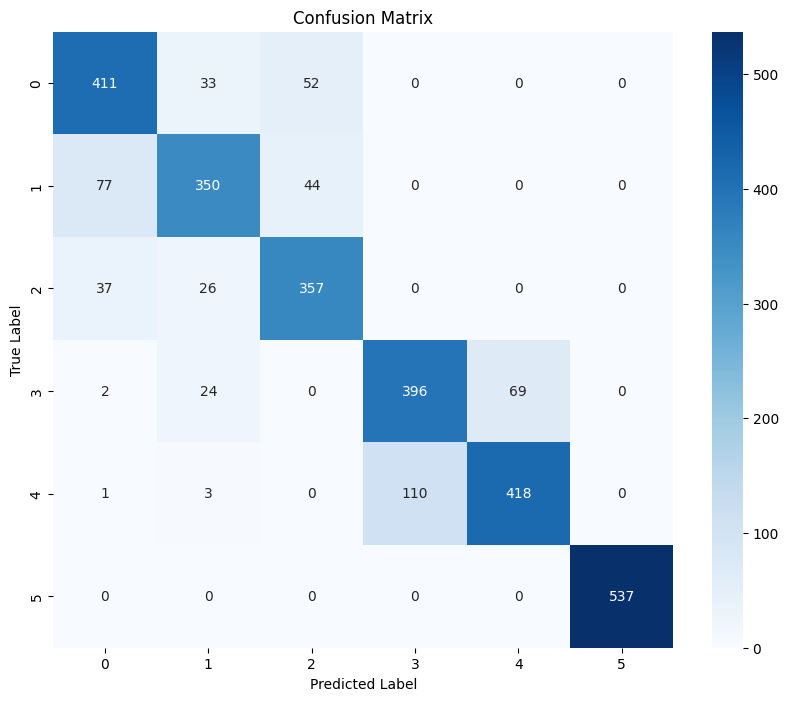

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Computational confusion matrix
cm = confusion_matrix(testy, predictions)

num_labels = len(np.unique(testy))

# draw heat map
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=range(num_labels), yticklabels=range(num_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

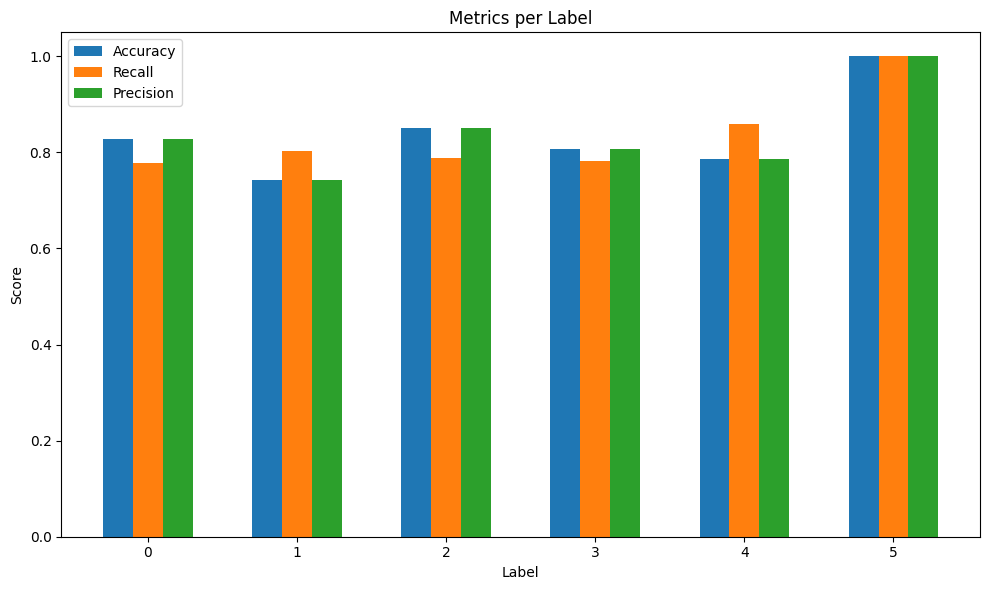

In [20]:
# Calculate the accuracy, recall, and precision of each label
accuracy_per_label = np.diag(cm) / cm.sum(axis=1)
recall_per_label = np.diag(cm) / cm.sum(axis=0)
precision_per_label = np.diag(cm) / cm.sum(axis=1)

# draw plot
plt.figure(figsize=(10, 6))
labels = range(num_labels)
width = 0.2

plt.bar(labels, accuracy_per_label, width, label='Accuracy')
plt.bar([label + width for label in labels], recall_per_label, width, label='Recall')
plt.bar([label + 2 * width for label in labels], precision_per_label, width, label='Precision')

plt.xlabel('Label')
plt.ylabel('Score')
plt.title('Metrics per Label')
plt.xticks([label + width for label in labels], labels)
plt.legend()
plt.tight_layout()
plt.show()

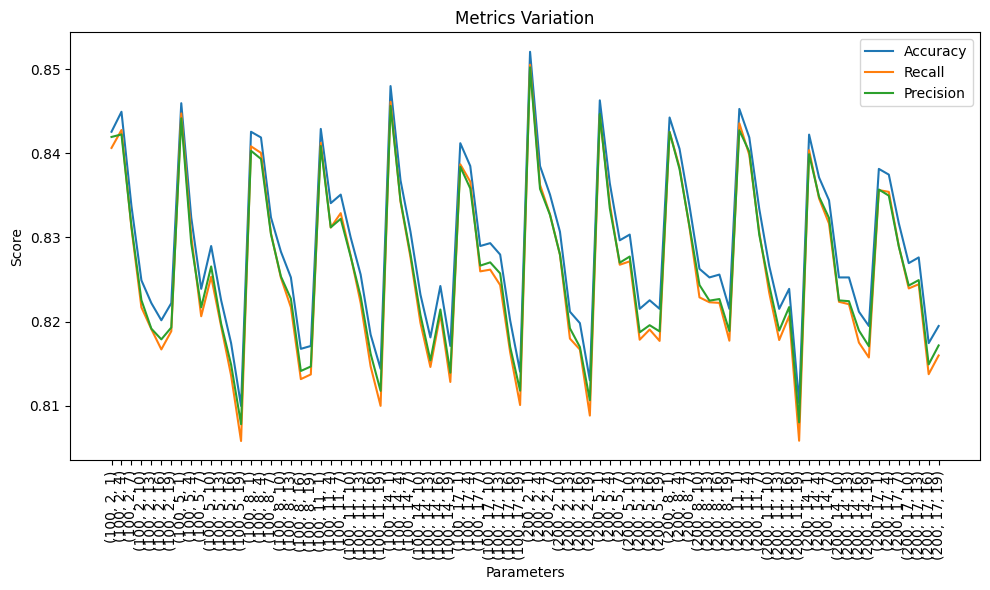

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# range and step 
n_estimators_range = np.arange(100, 300, 100)
min_samples_split_range = np.arange(2, 20, 3)
min_samples_leaf_range = np.arange(1, 20, 3)

# store result 
accuracy_scores = []
recall_scores = []
precision_scores = []

# 创建随机森林分类器
classifier = RandomForestClassifier()

for n_estimators in n_estimators_range:
    for min_samples_split in min_samples_split_range:
        for min_samples_leaf in min_samples_leaf_range:
        # set parameter 
            classifier.set_params(n_estimators=n_estimators, min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf)

            classifier.fit(trainX, trainy)
            predictions = classifier.predict(testX)
            accuracy = accuracy_score(testy, predictions)
            recall = recall_score(testy, predictions, average='macro')
            precision = precision_score(testy, predictions, average='macro')

            accuracy_scores.append(accuracy)
            recall_scores.append(recall)
            precision_scores.append(precision)

# draw plt
plt.figure(figsize=(10, 6))
x_ticks = range(len(accuracy_scores))
plt.plot(x_ticks, accuracy_scores, label='Accuracy')
plt.plot(x_ticks, recall_scores, label='Recall')
plt.plot(x_ticks, precision_scores, label='Precision')
plt.xlabel('Parameters')
plt.ylabel('Score')
plt.title('Metrics Variation')
plt.xticks(x_ticks, [f'({n_estimators_range[i]}, {min_samples_split_range[j]}, {min_samples_leaf_range[k]})'
                     for i in range(len(n_estimators_range))
                     for j in range(len(min_samples_split_range))
                     for k in range(len(min_samples_leaf_range))], rotation='vertical')
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
print(accuracy_scores[42])
print(recall_scores[42])
print(precision_scores[42])

0.8520529351883271
0.8505235151400048
0.8502053899268297
